## Import libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

## Load data

In [56]:
df = pd.read_csv("winemag-data_first150k.csv") 
del df['Unnamed: 0']
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [57]:
df.describe()

,points,price
count,150930.000000,137235.000000
mean,87.888418,33.131482
std,3.222392,36.322536
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


## Predict the price of a wine?

How many missing values are there in the variety column?

In [58]:
df.isnull().sum()/df.shape[0]*100

country         0.003313
description     0.000000
designation    30.302127
points          0.000000
price           9.073743
province        0.003313
region_1       16.603724
region_2       59.615053
variety         0.000000
winery          0.000000
dtype: float64

No values are missing in variety column. <br/>
9% of the values are missing in the price column.

In [59]:
df = df.dropna(subset=['price'])
df = df.dropna(subset=['country'])

Let´s add a description length since we have seen that it has a correlation with the price value

In [60]:
df['description_len'] = df['description'].apply(len)
df['description_len'] = df['description_len'] / max(df['description_len'])

In [61]:
df.corr()

,points,price,description_len
points,1.000000,0.459869,0.557371
price,0.459869,1.000000,0.254889
description_len,0.557371,0.254889,1.000000


## Gestion of the categorical columns

In [62]:
cat_df = df.select_dtypes(include=['object'])

In [63]:
print("There are {} columns with categorical variables in this dataset".format(cat_df.shape[1]))

There are 8 columns with categorical variables in this dataset


In [64]:
cat_df.head()

,country,description,designation,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [65]:
print("{} of the categorical columns have no missing values".format(np.sum(np.sum(cat_df.isnull())==0)))

5 of the categorical columns have no missing values


In [66]:
print("{} of the categorical columns have more than 50% missing values".format(np.sum(np.sum(cat_df.isnull())/cat_df.shape[0]>0.5)))

1 of the categorical columns have more than 50% missing values


In [67]:
print("{} of the categorical columns have more than 75% missing values".format(np.sum(np.sum(cat_df.isnull())/cat_df.shape[0]>0.75)))

0 of the categorical columns have more than 75% missing values


In [82]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop all the rows with no price
    df = df.dropna(subset=['price'], how='any', axis=0)
    
    # Create y as the price column
    y = df['points']
    
    # Create X as all the columns that are not the Salary column
    # Drop the points, description, region_1, region_2, winery, designation, province, variety from columns from X
    df = df.drop(['points', 'description', 'region_1', 'region_2', 'winery', 'designation', 'province', 'variety', 'country'], axis=1)

    #  For each numeric variable in X, fill the column with the mean value of the column.
    num_cols = df.select_dtypes(include=['int', 'float']).columns
    for col in num_cols:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Create dummy columns for all the categorical variables in X, drop the original columns
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y    

    
#Use the function to create X and y
X, y = clean_data(df)

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
print("The r-squared score for the model is {}".format(r2_score(y_test, y_test_preds)))

The r-squared score for the model is 0.4318959420307037


## Conclusion

If we only take the price and the description length as inputs and we apply a linear model, we have a R2 factor of 0.43

## Conclusion

Using a linear regression model taking into account, the description length, the country, and the points of the wine, we obtain a R^2 coefficient of 0.25. This is not a high score which shows that a linear model is not efficient.

## What about if we only keep the wine from the top 10 producers?

In [71]:
df.groupby('points')['price'].mean().sort_values(ascending=False)[0:10]

points
100    401.583333
99     289.525000
98     232.131579
97     178.000000
96     132.350970
95     108.927012
94      81.937812
93      66.425438
92      52.303609
91      43.755835
Name: price, dtype: float64

In [72]:
top_10_producers = ['US', 'Italie', 'France','Spain', 'Chile', 'Argentina', 'Australia', 'Portugal', 'New Zealand', 'Austria']
df = df[df['country'].isin(top_10_producers)]

In [73]:
X, y = clean_data(df)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
print("The r-squared score for the model is {}".format(r2_score(y_test, y_test_preds)))


The r-squared score for the model is 0.5037749387880612


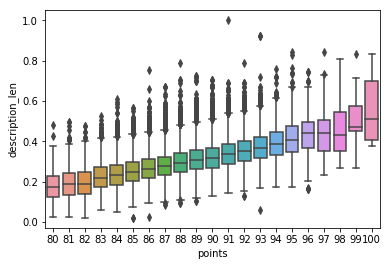

In [81]:
sns.boxplot('points', 'description_len', data=df)